In [1]:
import sys
import os
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from Levenshtein import distance as levenshtein_distance

import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd
from itertools import islice
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.io import read_image
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,v2

import tensorflow as tf

# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '/home/dornika/OCR_Project')))
from Scripts import Train
from Models import CRNN

2024-12-11 12:09:10.115448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 12:09:10.130998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 12:09:10.135981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 12:09:10.149084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 12:09:10.833728: W tensorflow/compiler/tf2

### **0 move and extract data**

### **1 Preparing data for Train OCR model**

 1.1 Load DataFrame

In [2]:
df = pd.read_csv("Data/train_df.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head(10)

,index,label,page,top_left_y,bot_right_y,top_left_x,bot_right_x,path
0,86244,درکنار,4468,590,620,45,96,04468_153_86244.png
1,275410,4335,4335,17,34,539,585,04335_0_275410.png
2,1234560,وتولد,5065,365,395,525,569,05065_71_1234560.png
3,782347,تراژدی‌ای,459,170,200,45,119,00459_42_782347.png
4,166182,افزود:استفاده,2664,435,465,192,285,02664_92_166182.png
5,77933,ریزگردها,2250,400,430,391,458,02250_87_77933.png
6,498681,سالگذشته,6715,330,360,507,573,06715_66_498681.png
7,186468,هولناک,5562,170,200,274,323,05562_35_186468.png
8,9457,اباالحسن,6711,135,165,282,342,06711_29_9457.png
9,899678,مواردرا,2937,135,165,341,398,02937_30_899678.png


1.2 Convert image path as key and it's label as value of dictionary.

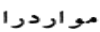

In [ ]:
test_transforms = v2.Compose([
    v2.Grayscale(),
    v2.Resize((32, 100)),
    v2.RandomPerspective(distortion_scale=0.6, p=1.0)
])
im = Image.open('Data/persian_unique_ocr_dataset/02937_30_899678.png')
im = test_transforms(im)
im.show()

In [3]:
dataset = df.set_index('path')['label'].to_dict()
dict(list(dataset.items())[0:10])

{'04468_153_86244.png': 'درکنار',
 '04335_0_275410.png': '4335',
 '05065_71_1234560.png': 'وتولد',
 '00459_42_782347.png': 'تراژدی\u200cای',
 '02664_92_166182.png': 'افزود:استفاده',
 '02250_87_77933.png': 'ریزگردها',
 '06715_66_498681.png': 'سالگذشته',
 '05562_35_186468.png': 'هولناک',
 '06711_29_9457.png': 'اباالحسن',
 '02937_30_899678.png': 'مواردرا'}

In [4]:
def find_longest_string(string_list):
  longest_string = ""
  for string in string_list:
    if len(string) > len(longest_string):
      longest_string = string
  return longest_string

In [5]:
def unique_chars_in_strings(string_list):
  """
  Finds the unique characters across a list of strings.

  Args:
    string_list: A list of strings.

  Returns:
    A set containing the unique characters found in the input strings.
  """
  unique_chars = set()
  for string in string_list:
    unique_chars.update(string)
  return unique_chars

# Example usage (assuming 'df' is your DataFrame and 'label' is the column name):
# unique_characters = unique_chars_in_strings(df['label'].tolist())
# print(unique_characters)

In [6]:
unique_characters = unique_chars_in_strings(df['label'].tolist())
print(unique_characters)
print(len(unique_characters))

{'“', 'خ', 'ر', ')', 'ع', '«', 'ض', 'ت', 'ظ', 'و', 'ج', 'ف', '1', 'ز', '6', '»', '؛', 'ً', '2', '؟', 'ح', '*', '+', '9', 'أ', '7', 'غ', '.', 'ص', 'ط', 'ۀ', 'ؤ', 'ل', 'ا', 'ق', '0', 'ث', 'ک', 'ه', 'چ', 'ذ', 'ن', '(', 'س', ':', '4', 'ش', 'م', 'د', '،', '/', 'ی', 'ئ', 'ژ', 'آ', '8', '”', 'پ', '5', '%', '3', 'گ', 'ب', '\u200c', '!'}
65


In [6]:
# Assuming 'df' is your DataFrame and 'label' is the column containing the strings
rows_with_specific_char = df[df['label'].str.contains('أ', na=False)]
# pd.set_option('display.max_rows', df.shape[0]+1)
rows_with_specific_char

,index,label,page,top_left_y,bot_right_y,top_left_x,bot_right_x,path
748,403787,علأ,5919,660,690,297,321,05919_212_403787.png
1422,23362,نشأت,1714,645,675,203,241,01714_165_23362.png
1925,1271277,تأکیدی,1000,450,480,263,318,01000_104_1271277.png
2315,1225904,بی‌شکمتأثر,5076,450,480,299,375,05076_123_1225904.png
3194,5551,تأسیسات,702,240,270,445,507,00702_50_5551.png
...,...,...,...,...,...,...,...,...
51535,36610,هیأت,918,240,270,363,402,00918_60_36610.png
52642,930031,أضلالهم،,1296,575,605,461,522,01296_168_930031.png
53126,103190,مسأله,5248,380,410,396,431,05248_109_103190.png
53646,63631,مأموران,5533,715,745,172,229,05533_195_63631.png


In [7]:
t = find_longest_string(df['label'].tolist())
print(t,len(t))

یکشنبه20مهر1399برگزار 21


In [8]:
char_to_index = {
    '!': 1, '%': 2, '(': 3, ')': 4, '*': 5, '+': 6,
    '/': 7, '0': 8, '1': 9, '2': 10, '3': 11, '4': 12,
    '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, ':': 18,
    '؛': 19, '؟': 20, 'آ': 21, 'أ': 22, 'ؤ': 23, 'ئ': 24,
    'ا': 25, 'ب': 26, 'پ': 27, 'ت': 28, 'ث': 29, 'ج': 30,
    'چ': 31, 'ح': 32, 'خ': 33, 'د': 34, 'ذ': 35, 'ر': 36,
    'ز': 37, 'ژ': 38, 'س': 39, 'ش': 40, 'ص': 41, 'ض': 42,
    'ط': 43, 'ظ': 44, 'ع': 45, 'غ': 46, 'ف': 47, 'ق': 48,
    'ک': 49, 'گ': 50, 'ل': 51, 'م': 52, 'ن': 53, 'ه': 54,
    'و': 55, 'ی': 56, 'ً': 57, '،': 58, '“': 59, '”': 60,
    '«': 61, '»': 62, '\u200c': 63, '.': 64, 'ۀ': 65
}
char_list =['!', '%', '(', ')', '*', '+', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '؛', '؟', 'آ', 'أ', 'ؤ', 'ئ', 'ا', 'ب', 'پ', 'ت', 'ث', 'ج', 'چ', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'ژ', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ک', 'گ', 'ل', 'م', 'ن', 'ه', 'و', 'ی', 'ً', '،', '“', '”', '«', '»', '\u200c', '.', 'ۀ']

1.3 Custom Torch dataclass

In [9]:
class OCRDataset(Dataset):
    def __init__(self, image_dir, labels, char_to_index, input_length, transform=None):
        """
        Args:
            image_dir (string): Path to the directory with images.
            labels (dict): A dictionary mapping image filenames to labels (e.g., text annotations).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_dir = image_dir
        self.labels = labels
        self.transform = transform
        self.image_files = list(self.labels.keys())
        self.char_to_index = char_to_index
        self.input_length = input_length

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")  # Load image
        label = self.labels[self.image_files[idx]]  # Load corresponding label (text)

        target_indices = [self.char_to_index[char] for char in label]

        # Get target length
        target_length = len(target_indices)

        # Convert to tensor if required by your model
        target_indices = torch.tensor(target_indices, dtype=torch.long)
        input_length = torch.tensor(self.input_length, dtype=torch.long)
        target_length = torch.tensor(target_length, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, target_indices, input_length ,target_length

1.4 Apply Data Augmentation and Preprocessing

In [10]:
train_transforms = v2.Compose([
    v2.Grayscale(),
    v2.Resize((32, 100)),              # Resize all images to 128x128
    # v2.RandoRotation(10),             # Random rotation within 10 degrees
    # v2.RandmomPerspective(distortion_scale=0.3, p=1.0),
    # v2.ColorJitter(brightness=0.5),     # Random brightness adjustments
    # v2.RandomAffine(translate=(0.1, 0.1)),  # Random translation
    v2.ToTensor(),                      # Convert PIL image to a PyTorch Tensor
    v2.Normalize((0.0,), (0.1,))        # Normalize (mean, std) for grayscale images
])

val_transforms = v2.Compose([
    v2.Grayscale(),
    v2.Resize((32, 40)),
    v2.ToTensor(),
    v2.Normalize((0.0,), (0.1,))
])

/home/dornika/OCR_Project/OCR_env/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


1.5 Split data to Train, test and validation with proportion of 80%, 10% and 10% respectively.

In [11]:
img_dir = "Data/persian_unique_ocr_dataset"

In [12]:
dataset = OCRDataset(img_dir, dataset, char_to_index , input_length=24,transform=train_transforms)
total_size = len(dataset)

# Define split sizes (e.g., 80% training, 10% validation, 10% testing)
train_size = int(0.8 * total_size)
# val_size = int(0.1 * total_size)
val_size = total_size - train_size  # Ensures no data leakage

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [14]:
def collate_fn(batch):
  """Custom collate function to handle variable-length sequences.

  Args:
      batch: A list of data samples, where each sample is a tuple
             of (image, label, length).

  Returns:
      A tuple containing:
          images: A batched tensor of images.
          labels: A padded tensor of labels.
          target_lengths: A tensor of label lengths.
  """
  images, labels, input_lengths, taget_lengths = zip(*batch)

  # Pad the labels to the maximum length in the batch
  labels = pad_sequence(labels, batch_first=True, padding_value=0)

  # Stack the images and lengths
  images = torch.stack(images, 0)
  input_lengths = torch.tensor(input_lengths)
  taget_lengths = torch.tensor(taget_lengths)

  return images, labels, input_lengths, taget_lengths

In [15]:
train_data = DataLoader(train_dataset, batch_size=200, shuffle=True,  collate_fn=collate_fn)
# test_data = DataLoader(test_dataset, batch_size=200, shuffle=True,  collate_fn=collate_fn)
val_data = DataLoader(val_dataset, batch_size=200, shuffle=True,  collate_fn=collate_fn)

### **2 OCR model architecture**

In [17]:
class CRNN(nn.Module):
    def __init__(self, imgH=32, num_channels=1, num_classes=66, hidden_units=256):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1),  # Conv1: #maps: 64, k:3 × 3, s:1, p:1
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  # MaxPool: Window:2 × 2, s:2

            # Second Conv Block (Conv2)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv2: #maps: 128, k:3 × 3, s:1, p:1
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  # MaxPool: Window:2 × 2, s:2

            # Third Conv Block (Conv3, Conv4)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv3: #maps: 256, k:3 × 3, s:1, p:1
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Conv4: #maps: 256, k:3 × 3, s:1, p:1
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),  # MaxPool: Window:2 × 2, s:2

            # Fourth Conv Block (Conv5)
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Conv5: #maps: 512, k:3 × 3, s:1, p:1
            # nn.MaxPool2d(kernel_size=(1, 2), stride=(2)),
            nn.BatchNorm2d(512),
            # Fifth Conv Block (Conv6)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # Conv6: #maps: 512, k:3 × 3, s:1, p:1
            nn.BatchNorm2d(512),
            # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # Conv6: #maps: 512, k:3 × 3, s:1, p:1
            # nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),  # MaxPool: Window:1 × 2, s:2

            # Sixth Conv Block (Conv7)
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),  # Conv7: #maps: 512, k:2 × 2, s:1, p:0
            # nn.MaxPool2d(kernel_size=(1, 2), stride=(2))  # MaxPool: Window:1 × 2, s:2
        )
        self.rnn1 = nn.LSTM(512, hidden_units, bidirectional=True, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_units * 2, hidden_units, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_units * 2, num_classes)
    def forward(self, x):
              # CNN Feature extraction
        conv_out = self.cnn(x)  # Shape: (batch_size, 512, W/16, 1)
        # Permute the dimensions to (batch_size, width, channels) -> suitable for RNN (LSTM)
        b, c, h, w = conv_out.size()
        assert h == 1, "Height of conv output must be 1"
        conv_out = conv_out.squeeze(2)  # Remove height dimension, now shape is (batch_size, 512, W/16)
        conv_out = conv_out.permute(0, 2, 1)  # Shape: (batch_size, W/16, 512)
        rnn_out, _ = self.rnn1(conv_out)
        rnn_out, _ = self.rnn2(rnn_out)
        output = self.fc(rnn_out)
        return output.log_softmax(2)

In [16]:
# Assuming the CRNN class is already defined
num_classes = 66  # Adjust for Persian characters + numbers + punctuation + blank token
model = CRNN(num_classes=num_classes)
# Define CTC Loss and Optimizer
criterion = nn.CTCLoss(blank=0)  # 0 as the blank token index
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch:  [1/100]
Train_Loss: 3.625423447726524, Train_character_accuracy: 0.0006619781168774035, Train_word_accuracy: 0.0, Train_WER: 6.517305936073059, Train_CER: 0.9988683845794515
Val_Loss: 3.256110906600952, Val_character_accuracy: 0.011660471242419179, Val_word_accuracy: 0.0, Val_WER: 6.035068493150685, Val_CER: 0.9317304922169423
Improved Train_Loss: 3.625423447726524 -> 3.625423447726524
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.256110906600952 -> 3.256110906600952
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.9988683845794515 -> 0.9988683845794515
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_

Epoch:  [2/100]
Train_Loss: 2.993135662383685, Train_character_accuracy: 0.055284878819273596, Train_word_accuracy: 0.000136986301369863, Train_WER: 5.480159817351598, Train_CER: 0.8351357950194176
Val_Loss: 2.999572602185336, Val_character_accuracy: 0.07043072687021608, Val_word_accuracy: 0.0006392694063926941, Val_WER: 5.3782648401826485, Val_CER: 0.8083158113768932
Improved Train_Loss: 3.625423447726524 -> 2.993135662383685
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.256110906600952 -> 2.999572602185336
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.9988683845794515 -> 0.8351357950194176
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics

Epoch:  [3/100]
Train_Loss: 2.2172386733364298, Train_character_accuracy: 0.1629821519549439, Train_word_accuracy: 0.09061643835616438, Train_WER: 4.253196347031963, Train_CER: 0.610979631219341
Val_Loss: 2.607157733223655, Val_character_accuracy: 0.16451086336946177, Val_word_accuracy: 0.08447488584474885, Val_WER: 4.264383561643836, Val_CER: 0.607917520386539
Improved Train_Loss: 2.993135662383685 -> 2.2172386733364298
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.999572602185336 -> 2.607157733223655
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.8351357950194176 -> 0.610979631219341
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Tr

Epoch:  [4/100]
Train_Loss: 1.5117436391577872, Train_character_accuracy: 0.27107388535392163, Train_word_accuracy: 0.13837899543378995, Train_WER: 3.122945205479452, Train_CER: 0.4305019065028551
Val_Loss: 1.6389420379291881, Val_character_accuracy: 0.2536269650128635, Val_word_accuracy: 0.13990867579908675, Val_WER: 3.028310502283105, Val_CER: 0.4143525822601061
Improved Train_Loss: 2.2172386733364298 -> 1.5117436391577872
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.607157733223655 -> 1.6389420379291881
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.610979631219341 -> 0.4305019065028551
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_l

Epoch:  [5/100]
Train_Loss: 0.9382282770387659, Train_character_accuracy: 0.4177697520885427, Train_word_accuracy: 0.2638356164383562, Train_WER: 2.0888584474885845, Train_CER: 0.27088369653012706
Val_Loss: 1.120872816172513, Val_character_accuracy: 0.40147841829830444, Val_word_accuracy: 0.21817351598173515, Val_WER: 2.414703196347032, Val_CER: 0.3166696997999747
Improved Train_Loss: 1.5117436391577872 -> 0.9382282770387659
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 1.6389420379291881 -> 1.120872816172513
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.4305019065028551 -> 0.27088369653012706
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics

Epoch:  [6/100]
Train_Loss: 0.597576814563307, Train_character_accuracy: 0.5613997108025824, Train_word_accuracy: 0.42773972602739724, Train_WER: 1.3886529680365296, Train_CER: 0.16973763746934242
Val_Loss: 0.5795371516184373, Val_character_accuracy: 0.6213546467268293, Val_word_accuracy: 0.4736073059360731, Val_WER: 1.2632876712328767, Val_CER: 0.15250314097855333
Improved Train_Loss: 0.9382282770387659 -> 0.597576814563307
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 1.120872816172513 -> 0.5795371516184373
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.27088369653012706 -> 0.16973763746934242
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metric

Epoch:  [7/100]
Train_Loss: 0.41795798197184525, Train_character_accuracy: 0.6585840687927891, Train_word_accuracy: 0.5511872146118721, Train_WER: 0.9935388127853881, Train_CER: 0.11650874459867355
Val_Loss: 0.3845277266068892, Val_character_accuracy: 0.7020289767709395, Val_word_accuracy: 0.5938812785388128, Val_WER: 0.8755251141552511, Val_CER: 0.10263710652952134
Improved Train_Loss: 0.597576814563307 -> 0.41795798197184525
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.5795371516184373 -> 0.3845277266068892
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.16973763746934242 -> 0.11650874459867355
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/met

Epoch:  [8/100]
Train_Loss: 0.3201246637187592, Train_character_accuracy: 0.720933330524642, Train_word_accuracy: 0.6296347031963471, Train_WER: 0.772648401826484, Train_CER: 0.0888534968315758
Val_Loss: 0.528291960737922, Val_character_accuracy: 0.5736401378041868, Val_word_accuracy: 0.4413698630136986, Val_WER: 1.1917808219178083, Val_CER: 0.1535851872840612
Improved Train_Loss: 0.41795798197184525 -> 0.3201246637187592
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.11650874459867355 -> 0.0888534968315758
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.5511872146118721 -> 0.6296347031963471
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accuracy.pth'.
Me

Epoch:  [9/100]
Train_Loss: 0.2676053811970367, Train_character_accuracy: 0.7597223421458178, Train_word_accuracy: 0.6791552511415525, Train_WER: 0.6503196347031963, Train_CER: 0.07386581255737866
Val_Loss: 0.32914674336260014, Val_character_accuracy: 0.759755633865091, Val_word_accuracy: 0.6502283105022831, Val_WER: 0.7142465753424657, Val_CER: 0.08460802096386726
Improved Train_Loss: 0.3201246637187592 -> 0.2676053811970367
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.3845277266068892 -> 0.32914674336260014
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.0888534968315758 -> 0.07386581255737866
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metr

Epoch:  [10/100]
Train_Loss: 0.2072229373808865, Train_character_accuracy: 0.7989676537089747, Train_word_accuracy: 0.7330365296803653, Train_WER: 0.5134703196347032, Train_CER: 0.05673699363982558
Val_Loss: 0.25909285247325897, Val_character_accuracy: 0.785913706695692, Val_word_accuracy: 0.7073972602739727, Val_WER: 0.5965296803652969, Val_CER: 0.0678293866228363
Improved Train_Loss: 0.2676053811970367 -> 0.2072229373808865
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.32914674336260014 -> 0.25909285247325897
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.07386581255737866 -> 0.05673699363982558
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/me

Epoch:  [11/100]
Train_Loss: 0.18473159082948346, Train_character_accuracy: 0.8171897254646894, Train_word_accuracy: 0.7538356164383562, Train_WER: 0.461324200913242, Train_CER: 0.051044802775028784
Val_Loss: 0.2378936699845574, Val_character_accuracy: 0.7711221099311989, Val_word_accuracy: 0.6967123287671233, Val_WER: 0.5840182648401826, Val_CER: 0.06749806268071458
Improved Train_Loss: 0.2072229373808865 -> 0.18473159082948346
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.25909285247325897 -> 0.2378936699845574
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.05673699363982558 -> 0.051044802775028784
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs

Epoch:  [12/100]
Train_Loss: 0.15816098989144853, Train_character_accuracy: 0.8361021446233547, Train_word_accuracy: 0.7806164383561643, Train_WER: 0.39885844748858446, Train_CER: 0.043524808592185806
Val_Loss: 0.22902131974697112, Val_character_accuracy: 0.7810956800085862, Val_word_accuracy: 0.701917808219178, Val_WER: 0.5583561643835616, Val_CER: 0.06621106807391212
Improved Train_Loss: 0.18473159082948346 -> 0.15816098989144853
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.2378936699845574 -> 0.22902131974697112
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.051044802775028784 -> 0.043524808592185806
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at '

Epoch:  [13/100]
Train_Loss: 0.1464894671826602, Train_character_accuracy: 0.8465440277013588, Train_word_accuracy: 0.7962785388127854, Train_WER: 0.3679908675799087, Train_CER: 0.040265492346843866
Val_Loss: 0.2170384558764371, Val_character_accuracy: 0.8063304606348889, Val_word_accuracy: 0.7402739726027397, Val_WER: 0.4963470319634703, Val_CER: 0.058330252549865326
Improved Train_Loss: 0.15816098989144853 -> 0.1464894671826602
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.22902131974697112 -> 0.2170384558764371
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.043524808592185806 -> 0.040265492346843866
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Lo

Epoch:  [14/100]
Train_Loss: 0.12742438936206305, Train_character_accuracy: 0.8626977406788922, Train_word_accuracy: 0.8178767123287671, Train_WER: 0.3208675799086758, Train_CER: 0.03475622165394312
Val_Loss: 0.1929018345746127, Val_character_accuracy: 0.8205835672872482, Val_word_accuracy: 0.765662100456621, Val_WER: 0.4374429223744292, Val_CER: 0.051093007330697625
Improved Train_Loss: 0.1464894671826602 -> 0.12742438936206305
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.2170384558764371 -> 0.1929018345746127
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.040265492346843866 -> 0.03475622165394312
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/

Epoch:  [15/100]
Train_Loss: 0.13013523453038578, Train_character_accuracy: 0.8601458214923898, Train_word_accuracy: 0.8150913242009132, Train_WER: 0.32271689497716893, Train_CER: 0.03560292594753609
Val_Loss: 0.19640098783102902, Val_character_accuracy: 0.8211667406199482, Val_word_accuracy: 0.7582648401826484, Val_WER: 0.4589041095890411, Val_CER: 0.052470147006439906
Improved Val_character_accuracy: 0.8205835672872482 -> 0.8211667406199482
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [16/100]
Train_Loss: 0.12260202281006939, Train_character_accuracy: 0.8669347541634116, Train_word_accuracy: 0.8231963470319634, Train_WER: 0.30605022831050227, Train_CER: 0.03370359582118987
Val_Loss: 0.16836208497936075, Val_character_accuracy: 0.8449675285685225, Val_word_accuracy: 0.7900456621004566, Val_WER: 0.39095890410958906, Val_CER: 0.04428332009192097
Improved Train_Loss: 0.12742438936206305 -> 0.12260202281006939
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1929018345746127 -> 0.16836208497936075
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.03475622165394312 -> 0.03370359582118987
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'L

Epoch:  [17/100]
Train_Loss: 0.10684541759153479, Train_character_accuracy: 0.880876898149742, Train_word_accuracy: 0.8428995433789954, Train_WER: 0.26767123287671235, Train_CER: 0.029116732935750917
Val_Loss: 0.16674368625337427, Val_character_accuracy: 0.8505578747804037, Val_word_accuracy: 0.7897716894977169, Val_WER: 0.3817351598173516, Val_CER: 0.04413637410014483
Improved Train_Loss: 0.12260202281006939 -> 0.10684541759153479
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.16836208497936075 -> 0.16674368625337427
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.03370359582118987 -> 0.029116732935750917
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at '

Epoch:  [18/100]
Train_Loss: 0.11721631296013044, Train_character_accuracy: 0.8719285509941576, Train_word_accuracy: 0.8288812785388128, Train_WER: 0.290365296803653, Train_CER: 0.03235576713069662
Val_Loss: 0.14655768302353947, Val_character_accuracy: 0.855889388807691, Val_word_accuracy: 0.808310502283105, Val_WER: 0.3463013698630137, Val_CER: 0.03910969795300131
Improved Val_Loss: 0.16674368625337427 -> 0.14655768302353947
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_character_accuracy: 0.8505578747804037 -> 0.855889388807691
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [19/100]
Train_Loss: 0.10125986956161996, Train_character_accuracy: 0.8860423843170127, Train_word_accuracy: 0.8486986301369863, Train_WER: 0.25333333333333335, Train_CER: 0.027773291668147803
Val_Loss: 0.4243397978219119, Val_character_accuracy: 0.6175035365725137, Val_word_accuracy: 0.5092237442922375, Val_WER: 0.9059360730593607, Val_CER: 0.11933477954417132
Improved Train_Loss: 0.10684541759153479 -> 0.10125986956161996
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.029116732935750917 -> 0.027773291668147803
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.8428995433789954 -> 0.8486986301369863
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accu

Epoch:  [20/100]
Train_Loss: 0.10918901625969639, Train_character_accuracy: 0.8764366850572007, Train_word_accuracy: 0.835365296803653, Train_WER: 0.27488584474885847, Train_CER: 0.030768366458177845
Val_Loss: 0.14858858111229808, Val_character_accuracy: 0.85523093394782, Val_word_accuracy: 0.8080365296803653, Val_WER: 0.3421004566210046, Val_CER: 0.03907806505860919


Epoch:  [21/100]
Train_Loss: 0.09986568017773433, Train_character_accuracy: 0.8846717659205579, Train_word_accuracy: 0.846689497716895, Train_WER: 0.2517808219178082, Train_CER: 0.028188215107038526
Val_Loss: 0.18041090856898914, Val_character_accuracy: 0.8276094899803774, Val_word_accuracy: 0.7719634703196347, Val_WER: 0.4084931506849315, Val_CER: 0.04780521234996618
Improved Train_Loss: 0.10125986956161996 -> 0.09986568017773433
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.


Epoch:  [22/100]
Train_Loss: 0.10650452566609535, Train_character_accuracy: 0.882412580569908, Train_word_accuracy: 0.8418036529680365, Train_WER: 0.26344748858447486, Train_CER: 0.029553706484041747
Val_Loss: 0.29781630066308107, Val_character_accuracy: 0.7873208762277769, Val_word_accuracy: 0.7062100456621004, Val_WER: 0.651689497716895, Val_CER: 0.07582120510126363


Epoch:  [23/100]
Train_Loss: 0.08740910084824584, Train_character_accuracy: 0.8978450037416276, Train_word_accuracy: 0.8646575342465753, Train_WER: 0.2219634703196347, Train_CER: 0.024400765737373528
Val_Loss: 0.1715012104673819, Val_character_accuracy: 0.8485966324347509, Val_word_accuracy: 0.7798173515981736, Val_WER: 0.3933333333333333, Val_CER: 0.04660242075429318
Improved Train_Loss: 0.09986568017773433 -> 0.08740910084824584
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.027773291668147803 -> 0.024400765737373528
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.8486986301369863 -> 0.8646575342465753
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accur

Epoch:  [24/100]
Train_Loss: 0.0730384587050845, Train_character_accuracy: 0.9113244527498149, Train_word_accuracy: 0.8828082191780822, Train_WER: 0.18744292237442922, Train_CER: 0.020230711068084897
Val_Loss: 0.1315829650922255, Val_character_accuracy: 0.8792644760806314, Val_word_accuracy: 0.831324200913242, Val_WER: 0.28885844748858447, Val_CER: 0.03415278068372984
Improved Train_Loss: 0.08740910084824584 -> 0.0730384587050845
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.14655768302353947 -> 0.1315829650922255
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.024400765737373528 -> 0.020230711068084897
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Lo

Epoch:  [25/100]
Train_Loss: 0.07905166380141423, Train_character_accuracy: 0.9046242072531956, Train_word_accuracy: 0.8726712328767123, Train_WER: 0.20273972602739726, Train_CER: 0.02248085460573797
Val_Loss: 0.20202456252141432, Val_character_accuracy: 0.833595159013149, Val_word_accuracy: 0.7680365296803653, Val_WER: 0.44986301369863013, Val_CER: 0.05195915943361764


Epoch:  [26/100]
Train_Loss: 0.10090958383189488, Train_character_accuracy: 0.8863110377299774, Train_word_accuracy: 0.8461643835616438, Train_WER: 0.2478538812785388, Train_CER: 0.028278861752031734
Val_Loss: 0.1591545278375799, Val_character_accuracy: 0.8696911778746125, Val_word_accuracy: 0.8073972602739726, Val_WER: 0.32703196347031965, Val_CER: 0.03924962835511417


Epoch:  [27/100]
Train_Loss: 0.08167856047142587, Train_character_accuracy: 0.9022874377468325, Train_word_accuracy: 0.869337899543379, Train_WER: 0.20947488584474885, Train_CER: 0.023138712099514087
Val_Loss: 0.2034642382101579, Val_character_accuracy: 0.7890329253723801, Val_word_accuracy: 0.7144292237442922, Val_WER: 0.4699543378995434, Val_CER: 0.058504169341927495


Epoch:  [28/100]
Train_Loss: 0.08558592324455579, Train_character_accuracy: 0.9047317808602555, Train_word_accuracy: 0.8667123287671233, Train_WER: 0.2099771689497717, Train_CER: 0.023975555887659875
Val_Loss: 5.167543636668812, Val_character_accuracy: 0.08129062044430889, Val_word_accuracy: 0.013881278538812785, Val_WER: 5.314977168949771, Val_CER: 0.7792486609792686


Epoch:  [29/100]
Train_Loss: 0.1124534181331935, Train_character_accuracy: 0.8769586608067975, Train_word_accuracy: 0.8298173515981735, Train_WER: 0.2803881278538813, Train_CER: 0.03226019527867572
Val_Loss: 0.15424940409985455, Val_character_accuracy: 0.8635672124868584, Val_word_accuracy: 0.8081278538812785, Val_WER: 0.3323287671232877, Val_CER: 0.039153686621687805


Epoch:  [30/100]
Train_Loss: 0.08630654316174385, Train_character_accuracy: 0.8990970815214882, Train_word_accuracy: 0.8643150684931507, Train_WER: 0.21844748858447488, Train_CER: 0.02465432856248306
Val_Loss: 0.13202722126787358, Val_character_accuracy: 0.873171463096394, Val_word_accuracy: 0.827945205479452, Val_WER: 0.30018264840182646, Val_CER: 0.03468028866440589


Epoch:  [31/100]
Train_Loss: 0.06546320231231652, Train_character_accuracy: 0.9175565065391397, Train_word_accuracy: 0.8907762557077625, Train_WER: 0.17136986301369864, Train_CER: 0.018518639971524423
Val_Loss: 0.1601841306144541, Val_character_accuracy: 0.852639016678008, Val_word_accuracy: 0.7873059360730593, Val_WER: 0.35771689497716896, Val_CER: 0.04314175208824048
Improved Train_Loss: 0.0730384587050845 -> 0.06546320231231652
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.020230711068084897 -> 0.018518639971524423
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.8828082191780822 -> 0.8907762557077625
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accur

Epoch:  [32/100]
Train_Loss: 0.059359539614896796, Train_character_accuracy: 0.92423144037305, Train_word_accuracy: 0.8992465753424658, Train_WER: 0.15515981735159817, Train_CER: 0.016913538954181576
Val_Loss: 0.13511295738545331, Val_character_accuracy: 0.8824674593775117, Val_word_accuracy: 0.8285844748858447, Val_WER: 0.29397260273972603, Val_CER: 0.034224907753842404
Improved Train_Loss: 0.06546320231231652 -> 0.059359539614896796
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.018518639971524423 -> 0.016913538954181576
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_character_accuracy: 0.8792644760806314 -> 0.8824674593775117
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_ch

Epoch:  [33/100]
Train_Loss: 0.05927742293878505, Train_character_accuracy: 0.9246552164710903, Train_word_accuracy: 0.8988812785388128, Train_WER: 0.15388127853881278, Train_CER: 0.016856105404896175
Val_Loss: 0.11390227214856581, Val_character_accuracy: 0.8906925877145949, Val_word_accuracy: 0.8503196347031964, Val_WER: 0.24776255707762557, Val_CER: 0.02899485724004365
Improved Train_Loss: 0.059359539614896796 -> 0.05927742293878505
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1315829650922255 -> 0.11390227214856581
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.016913538954181576 -> 0.016856105404896175
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved a

Epoch:  [34/100]
Train_Loss: 0.059337722035507634, Train_character_accuracy: 0.9223142646283625, Train_word_accuracy: 0.8959360730593607, Train_WER: 0.15710045662100455, Train_CER: 0.017311292438831772
Val_Loss: 0.11974092356183312, Val_character_accuracy: 0.8908384877672435, Val_word_accuracy: 0.8455707762557078, Val_WER: 0.26118721461187216, Val_CER: 0.030396498438675805
Improved Val_character_accuracy: 0.8906925877145949 -> 0.8908384877672435
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [35/100]
Train_Loss: 0.06757522786895162, Train_character_accuracy: 0.9165754846382268, Train_word_accuracy: 0.8864155251141552, Train_WER: 0.1734931506849315, Train_CER: 0.019302244155810888
Val_Loss: 0.1898271303285252, Val_character_accuracy: 0.8549458556657245, Val_word_accuracy: 0.8011872146118721, Val_WER: 0.4121461187214612, Val_CER: 0.045613701974796576


Epoch:  [36/100]
Train_Loss: 0.07536302071455951, Train_character_accuracy: 0.9103224017068906, Train_word_accuracy: 0.8764155251141552, Train_WER: 0.19116438356164384, Train_CER: 0.021884415656559294
Val_Loss: 0.22771447924050417, Val_character_accuracy: 0.8261049300985198, Val_word_accuracy: 0.7417351598173516, Val_WER: 0.4684018264840183, Val_CER: 0.05756821143045112


Epoch:  [37/100]
Train_Loss: 0.08786646923109821, Train_character_accuracy: 0.8991119920786167, Train_word_accuracy: 0.8614611872146118, Train_WER: 0.21472602739726027, Train_CER: 0.02535374586627289
Val_Loss: 1.1012185703624378, Val_character_accuracy: 0.561484230008347, Val_word_accuracy: 0.2921461187214612, Val_WER: 1.623744292237443, Val_CER: 0.23386374801810156


Epoch:  [38/100]
Train_Loss: 0.09473161608593104, Train_character_accuracy: 0.8919220535478102, Train_word_accuracy: 0.8500228310502284, Train_WER: 0.23753424657534247, Train_CER: 0.02755410431927405
Val_Loss: 0.1296467581933195, Val_character_accuracy: 0.8801130365290203, Val_word_accuracy: 0.8288584474885845, Val_WER: 0.28191780821917806, Val_CER: 0.03358068192267056


Epoch:  [39/100]
Train_Loss: 0.068326685577631, Train_character_accuracy: 0.9158020914879245, Train_word_accuracy: 0.8860045662100456, Train_WER: 0.17570776255707762, Train_CER: 0.01965068123958451
Val_Loss: 0.12879071912982248, Val_character_accuracy: 0.8732181470248053, Val_word_accuracy: 0.8331506849315069, Val_WER: 0.2817351598173516, Val_CER: 0.03267056600278959


Epoch:  [40/100]
Train_Loss: 0.05447372741418886, Train_character_accuracy: 0.929681874065481, Train_word_accuracy: 0.905662100456621, Train_WER: 0.14242009132420091, Train_CER: 0.015650284654607886
Val_Loss: 0.13594877990809354, Val_character_accuracy: 0.8598686677964231, Val_word_accuracy: 0.8305022831050228, Val_WER: 0.28264840182648404, Val_CER: 0.03269977690432332
Improved Train_Loss: 0.05927742293878505 -> 0.05447372741418886
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.016856105404896175 -> 0.015650284654607886
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.8992465753424658 -> 0.905662100456621
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accur

Epoch:  [41/100]
Train_Loss: 0.051431436857132064, Train_character_accuracy: 0.9333361747418691, Train_word_accuracy: 0.9089954337899543, Train_WER: 0.13607305936073058, Train_CER: 0.014915918463256654
Val_Loss: 0.10972568650137295, Val_character_accuracy: 0.9025400545576248, Val_word_accuracy: 0.8671232876712329, Val_WER: 0.2152511415525114, Val_CER: 0.025367529876478518
Improved Train_Loss: 0.05447372741418886 -> 0.051431436857132064
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.11390227214856581 -> 0.10972568650137295
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.015650284654607886 -> 0.014915918463256654
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved

Epoch:  [42/100]
Train_Loss: 0.050575728132708435, Train_character_accuracy: 0.9341557155857906, Train_word_accuracy: 0.9096118721461187, Train_WER: 0.13376712328767124, Train_CER: 0.01495212113516007
Val_Loss: 0.2715357002886859, Val_character_accuracy: 0.7989375449885832, Val_word_accuracy: 0.7278538812785388, Val_WER: 0.5970776255707763, Val_CER: 0.06765930825665123
Improved Train_Loss: 0.051431436857132064 -> 0.050575728132708435
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_word_accuracy: 0.9089954337899543 -> 0.9096118721461187
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_word_accuracy.txt'.


Epoch:  [43/100]
Train_Loss: 0.07968567111040359, Train_character_accuracy: 0.9057352082034598, Train_word_accuracy: 0.868972602739726, Train_WER: 0.2012785388127854, Train_CER: 0.022928981008047657
Val_Loss: 0.17580254646864804, Val_character_accuracy: 0.8607614429906609, Val_word_accuracy: 0.78337899543379, Val_WER: 0.3526027397260274, Val_CER: 0.04460917652967781


Epoch:  [44/100]
Train_Loss: 0.0611757051250706, Train_character_accuracy: 0.9239921971478854, Train_word_accuracy: 0.8956849315068494, Train_WER: 0.1584931506849315, Train_CER: 0.01774743872798816
Val_Loss: 0.20140488201921636, Val_character_accuracy: 0.8358217693651336, Val_word_accuracy: 0.7812785388127854, Val_WER: 0.4500456621004566, Val_CER: 0.05078637641086219


Epoch:  [45/100]
Train_Loss: 0.05889266617936358, Train_character_accuracy: 0.925439324536928, Train_word_accuracy: 0.8989269406392694, Train_WER: 0.15191780821917808, Train_CER: 0.01716170194898884
Val_Loss: 0.10079032277519052, Val_character_accuracy: 0.9101932758399012, Val_word_accuracy: 0.8726940639269406, Val_WER: 0.20748858447488586, Val_CER: 0.024175903096107513
Improved Val_Loss: 0.10972568650137295 -> 0.10079032277519052
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_character_accuracy: 0.9025400545576248 -> 0.9101932758399012
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [46/100]
Train_Loss: 0.044743930146982684, Train_character_accuracy: 0.9405737140920236, Train_word_accuracy: 0.9192237442922374, Train_WER: 0.11769406392694064, Train_CER: 0.01311011519377545
Val_Loss: 0.11976305043155497, Val_character_accuracy: 0.8885681810228961, Val_word_accuracy: 0.8415525114155251, Val_WER: 0.2608219178082192, Val_CER: 0.030833330261635112
Improved Train_Loss: 0.050575728132708435 -> 0.044743930146982684
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.014915918463256654 -> 0.01311011519377545
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.9096118721461187 -> 0.9192237442922374
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_a

Epoch:  [47/100]
Train_Loss: 0.06216668774752312, Train_character_accuracy: 0.9249072048267285, Train_word_accuracy: 0.8943150684931507, Train_WER: 0.15509132420091323, Train_CER: 0.01822968893804171
Val_Loss: 0.14296613579446618, Val_character_accuracy: 0.8835783240594168, Val_word_accuracy: 0.8319634703196347, Val_WER: 0.28191780821917806, Val_CER: 0.03450772471061711


Epoch:  [48/100]
Train_Loss: 0.07130591516897558, Train_character_accuracy: 0.9157352244061874, Train_word_accuracy: 0.8820776255707763, Train_WER: 0.1780365296803653, Train_CER: 0.020713024466462383
Val_Loss: 0.1511391131715341, Val_character_accuracy: 0.8717095130847313, Val_word_accuracy: 0.813972602739726, Val_WER: 0.31680365296803653, Val_CER: 0.03833521360572976


Epoch:  [49/100]
Train_Loss: 0.06476570403024759, Train_character_accuracy: 0.9206130942552385, Train_word_accuracy: 0.8887899543378995, Train_WER: 0.16593607305936073, Train_CER: 0.019077127725286563
Val_Loss: 0.18616036041216416, Val_character_accuracy: 0.8312923814175077, Val_word_accuracy: 0.7601826484018265, Val_WER: 0.3873972602739726, Val_CER: 0.04874507315414478


Epoch:  [50/100]
Train_Loss: 0.054756494885370065, Train_character_accuracy: 0.9289633387434948, Train_word_accuracy: 0.9034246575342466, Train_WER: 0.14358447488584475, Train_CER: 0.016113655000959386
Val_Loss: 0.1396808385848999, Val_character_accuracy: 0.8839173198200913, Val_word_accuracy: 0.8288584474885845, Val_WER: 0.29077625570776255, Val_CER: 0.03462222120977794


Epoch:  [51/100]
Train_Loss: 0.04832915622383764, Train_character_accuracy: 0.9359347889146011, Train_word_accuracy: 0.912351598173516, Train_WER: 0.12792237442922375, Train_CER: 0.014416405005642249
Val_Loss: 0.10606923374262724, Val_character_accuracy: 0.9051717231440838, Val_word_accuracy: 0.869406392694064, Val_WER: 0.21351598173515982, Val_CER: 0.025403076540444533


Epoch:  [52/100]
Train_Loss: 0.040554319648710015, Train_character_accuracy: 0.9447731221079553, Train_word_accuracy: 0.9246803652968036, Train_WER: 0.10794520547945205, Train_CER: 0.011934364950059522
Val_Loss: 0.11943177756938067, Val_character_accuracy: 0.8970631429675208, Val_word_accuracy: 0.8484018264840183, Val_WER: 0.2501369863013699, Val_CER: 0.029489079024969014
Improved Train_Loss: 0.044743930146982684 -> 0.040554319648710015
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.01311011519377545 -> 0.011934364950059522
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.9192237442922374 -> 0.9246803652968036
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_

Epoch:  [53/100]
Train_Loss: 0.0538471263480377, Train_character_accuracy: 0.9321560846912902, Train_word_accuracy: 0.9047260273972603, Train_WER: 0.13789954337899543, Train_CER: 0.015801378819289343
Val_Loss: 0.16381338712843982, Val_character_accuracy: 0.8767638545541168, Val_word_accuracy: 0.8080365296803653, Val_WER: 0.3088584474885845, Val_CER: 0.04015978525333247


Epoch:  [54/100]
Train_Loss: 0.06563231293707406, Train_character_accuracy: 0.9191543201181882, Train_word_accuracy: 0.8871917808219179, Train_WER: 0.16799086757990866, Train_CER: 0.01931800765681551
Val_Loss: 0.11936966194347902, Val_character_accuracy: 0.8935474701578598, Val_word_accuracy: 0.8545205479452055, Val_WER: 0.23981735159817352, Val_CER: 0.0280753386000428


Epoch:  [55/100]
Train_Loss: 0.11525057254520725, Train_character_accuracy: 0.8785898865156746, Train_word_accuracy: 0.8231963470319634, Train_WER: 0.2752283105022831, Train_CER: 0.03367379821107451
Val_Loss: 0.14741180796514858, Val_character_accuracy: 0.8696213148473254, Val_word_accuracy: 0.8240182648401827, Val_WER: 0.297351598173516, Val_CER: 0.03594016924191019


Epoch:  [56/100]
Train_Loss: 0.06281026163601984, Train_character_accuracy: 0.9196514803309666, Train_word_accuracy: 0.8920319634703197, Train_WER: 0.1628082191780822, Train_CER: 0.01827251829162163
Val_Loss: 0.11091901104558598, Val_character_accuracy: 0.9053373982258109, Val_word_accuracy: 0.8652054794520548, Val_WER: 0.2191780821917808, Val_CER: 0.025946191372184842


Epoch:  [57/100]
Train_Loss: 0.047597602315961496, Train_character_accuracy: 0.936598280946092, Train_word_accuracy: 0.9131735159817351, Train_WER: 0.12420091324200913, Train_CER: 0.014166970774107961
Val_Loss: 0.12043917233293706, Val_character_accuracy: 0.8970949090839857, Val_word_accuracy: 0.8555251141552511, Val_WER: 0.23214611872146118, Val_CER: 0.028253826763623615


Epoch:  [58/100]
Train_Loss: 0.049584696630704896, Train_character_accuracy: 0.9347795413472827, Train_word_accuracy: 0.911255707762557, Train_WER: 0.1291324200913242, Train_CER: 0.014767375324433509
Val_Loss: 0.15789105607704682, Val_character_accuracy: 0.8706394075449911, Val_word_accuracy: 0.8108675799086758, Val_WER: 0.29397260273972603, Val_CER: 0.03840408841393828


Epoch:  [59/100]
Train_Loss: 0.05200313083555328, Train_character_accuracy: 0.9336755034030979, Train_word_accuracy: 0.9070319634703197, Train_WER: 0.13527397260273974, Train_CER: 0.015566961508975593
Val_Loss: 0.10806941051374783, Val_character_accuracy: 0.9093086836424349, Val_word_accuracy: 0.8705022831050229, Val_WER: 0.20666666666666667, Val_CER: 0.02444456846141608


Epoch:  [60/100]
Train_Loss: 0.045504902034453606, Train_character_accuracy: 0.9397387045315356, Train_word_accuracy: 0.9161187214611872, Train_WER: 0.12018264840182648, Train_CER: 0.013584489790936733
Val_Loss: 0.10939875902100042, Val_character_accuracy: 0.909622953719224, Val_word_accuracy: 0.8667579908675799, Val_WER: 0.21662100456621006, Val_CER: 0.02592565994824361


Epoch:  [61/100]
Train_Loss: 0.04307763142400681, Train_character_accuracy: 0.941564775846214, Train_word_accuracy: 0.9195205479452054, Train_WER: 0.1132648401826484, Train_CER: 0.01282528021472898
Val_Loss: 0.10043731297958981, Val_character_accuracy: 0.9066442985310955, Val_word_accuracy: 0.8695890410958904, Val_WER: 0.20310502283105022, Val_CER: 0.023797349971169886
Improved Val_Loss: 0.10079032277519052 -> 0.10043731297958981
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.


Epoch:  [62/100]
Train_Loss: 0.05297295994138065, Train_character_accuracy: 0.9329112753963354, Train_word_accuracy: 0.9055479452054794, Train_WER: 0.13641552511415525, Train_CER: 0.01583181077833894
Val_Loss: 0.17486112253232436, Val_character_accuracy: 0.8570045394433371, Val_word_accuracy: 0.7875799086757991, Val_WER: 0.351324200913242, Val_CER: 0.04333351733551063


Epoch:  [63/100]
Train_Loss: 0.04526459326176611, Train_character_accuracy: 0.9425131115318726, Train_word_accuracy: 0.9187899543378996, Train_WER: 0.11789954337899543, Train_CER: 0.013438818066982963
Val_Loss: 0.20435542274605145, Val_character_accuracy: 0.8377862140065421, Val_word_accuracy: 0.7751598173515982, Val_WER: 0.4368036529680365, Val_CER: 0.04985192960700827


Epoch:  [64/100]
Train_Loss: 0.047408913793765245, Train_character_accuracy: 0.9365551677684619, Train_word_accuracy: 0.9126255707762557, Train_WER: 0.12639269406392695, Train_CER: 0.01420215453193421
Val_Loss: 0.11214307607574896, Val_character_accuracy: 0.9065843883202482, Val_word_accuracy: 0.8659360730593607, Val_WER: 0.2250228310502283, Val_CER: 0.02625963916242342


Epoch:  [65/100]
Train_Loss: 0.06386035035223994, Train_character_accuracy: 0.9233512441509006, Train_word_accuracy: 0.8913470319634703, Train_WER: 0.16006849315068494, Train_CER: 0.018956618805732427
Val_Loss: 0.33991026309403505, Val_character_accuracy: 0.8060691035555507, Val_word_accuracy: 0.662648401826484, Val_WER: 0.5495890410958905, Val_CER: 0.07639768313108997


Epoch:  [66/100]
Train_Loss: 0.07467671281330662, Train_character_accuracy: 0.9116371112881152, Train_word_accuracy: 0.8742922374429224, Train_WER: 0.1882420091324201, Train_CER: 0.022026460524127944
Val_Loss: 0.12807348587296224, Val_character_accuracy: 0.8877140415383071, Val_word_accuracy: 0.8442922374429224, Val_WER: 0.25726027397260276, Val_CER: 0.03022165146381611


Epoch:  [67/100]
Train_Loss: 0.05398768286930916, Train_character_accuracy: 0.9317562021988267, Train_word_accuracy: 0.904703196347032, Train_WER: 0.14093607305936073, Train_CER: 0.0159933750681715
Val_Loss: 0.11250940906730565, Val_character_accuracy: 0.9015730964804739, Val_word_accuracy: 0.8673059360730594, Val_WER: 0.21424657534246574, Val_CER: 0.025514781130328866


Epoch:  [68/100]
Train_Loss: 0.043359299075521836, Train_character_accuracy: 0.939863867106246, Train_word_accuracy: 0.9182191780821918, Train_WER: 0.11883561643835616, Train_CER: 0.013243345636947994
Val_Loss: 0.1037237632681023, Val_character_accuracy: 0.9108533011183331, Val_word_accuracy: 0.8765296803652968, Val_WER: 0.19926940639269405, Val_CER: 0.023399730672165893
Improved Val_character_accuracy: 0.9101932758399012 -> 0.9108533011183331
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [69/100]
Train_Loss: 0.04173116576453866, Train_character_accuracy: 0.9438111390329983, Train_word_accuracy: 0.9211872146118721, Train_WER: 0.1113013698630137, Train_CER: 0.012631039901206152
Val_Loss: 0.5811047266830097, Val_character_accuracy: 0.694913659458614, Val_word_accuracy: 0.468310502283105, Val_WER: 0.9529680365296803, Val_CER: 0.14539464822969211


Epoch:  [70/100]
Train_Loss: 0.0483602162229416, Train_character_accuracy: 0.9361265928082239, Train_word_accuracy: 0.9103424657534247, Train_WER: 0.1252283105022831, Train_CER: 0.0146715128297389
Val_Loss: 0.10148340666835959, Val_character_accuracy: 0.9081996405416247, Val_word_accuracy: 0.8784474885844749, Val_WER: 0.2002739726027397, Val_CER: 0.02311613577152828


Epoch:  [71/100]
Train_Loss: 0.04305365611054854, Train_character_accuracy: 0.9415700268557302, Train_word_accuracy: 0.9192922374429223, Train_WER: 0.1136986301369863, Train_CER: 0.012983024829479826
Val_Loss: 0.14004435336047952, Val_character_accuracy: 0.8797864362620097, Val_word_accuracy: 0.8296803652968037, Val_WER: 0.26767123287671235, Val_CER: 0.03272568914287179


Epoch:  [72/100]
Train_Loss: 0.04237263623335862, Train_character_accuracy: 0.9427768758615341, Train_word_accuracy: 0.919703196347032, Train_WER: 0.11399543378995433, Train_CER: 0.013092272189851076
Val_Loss: 0.1228548946028406, Val_character_accuracy: 0.8962663426338461, Val_word_accuracy: 0.8552511415525114, Val_WER: 0.23168949771689498, Val_CER: 0.02820502723295464


Epoch:  [73/100]
Train_Loss: 0.040395655741566394, Train_character_accuracy: 0.9445409500594693, Train_word_accuracy: 0.9227853881278539, Train_WER: 0.1084703196347032, Train_CER: 0.012471405848688067
Val_Loss: 0.11703969538211823, Val_character_accuracy: 0.9055593293705412, Val_word_accuracy: 0.8610045662100456, Val_WER: 0.22484018264840183, Val_CER: 0.027329971069326005
Improved Train_Loss: 0.040554319648710015 -> 0.040395655741566394
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.


Epoch:  [74/100]
Train_Loss: 0.05977774896237948, Train_character_accuracy: 0.9249624432622157, Train_word_accuracy: 0.892716894977169, Train_WER: 0.15404109589041096, Train_CER: 0.018173670486684702
Val_Loss: 0.13254646916281093, Val_character_accuracy: 0.8897103642468625, Val_word_accuracy: 0.8453881278538813, Val_WER: 0.25616438356164384, Val_CER: 0.03035376158077502


Epoch:  [75/100]
Train_Loss: 0.050309833811094225, Train_character_accuracy: 0.9314906180693913, Train_word_accuracy: 0.9057990867579908, Train_WER: 0.13383561643835618, Train_CER: 0.015430979303681173
Val_Loss: 0.2494967447085814, Val_character_accuracy: 0.8213968274466101, Val_word_accuracy: 0.7304109589041096, Val_WER: 0.4982648401826484, Val_CER: 0.05885748715410704


Epoch:  [76/100]
Train_Loss: 0.04779223814504604, Train_character_accuracy: 0.9379513085704837, Train_word_accuracy: 0.9107990867579908, Train_WER: 0.12598173515981737, Train_CER: 0.014538985229663376
Val_Loss: 0.1462814461101185, Val_character_accuracy: 0.872101066894067, Val_word_accuracy: 0.8144292237442923, Val_WER: 0.28136986301369865, Val_CER: 0.03604299434584857


Epoch:  [77/100]
Train_Loss: 0.04742300215275048, Train_character_accuracy: 0.9390693142301026, Train_word_accuracy: 0.9117351598173516, Train_WER: 0.12618721461187216, Train_CER: 0.014587909621040264
Val_Loss: 0.166981802880764, Val_character_accuracy: 0.8642497507996094, Val_word_accuracy: 0.802648401826484, Val_WER: 0.34228310502283105, Val_CER: 0.04057075963872264


Epoch:  [78/100]
Train_Loss: 0.05896670071909961, Train_character_accuracy: 0.9255752511691311, Train_word_accuracy: 0.895662100456621, Train_WER: 0.1532648401826484, Train_CER: 0.017753388548015107
Val_Loss: 0.13490489599379626, Val_character_accuracy: 0.8857530632262499, Val_word_accuracy: 0.8356164383561644, Val_WER: 0.26666666666666666, Val_CER: 0.03281842426657729


Epoch:  [79/100]
Train_Loss: 0.07413152279544911, Train_character_accuracy: 0.9158204554393298, Train_word_accuracy: 0.876689497716895, Train_WER: 0.18381278538812784, Train_CER: 0.022081561665868676
Val_Loss: 0.18964944861151956, Val_character_accuracy: 0.863294828025387, Val_word_accuracy: 0.7906849315068493, Val_WER: 0.3664840182648402, Val_CER: 0.04433487272647117


Epoch:  [80/100]
Train_Loss: 0.0421995241365068, Train_character_accuracy: 0.9425812169792593, Train_word_accuracy: 0.9203424657534247, Train_WER: 0.11378995433789954, Train_CER: 0.012935282149537956
Val_Loss: 0.15856841924515638, Val_character_accuracy: 0.8815497505175436, Val_word_accuracy: 0.8193607305936073, Val_WER: 0.29041095890410956, Val_CER: 0.03576322918755804


Epoch:  [81/100]
Train_Loss: 0.038566026964212116, Train_character_accuracy: 0.9491785416481049, Train_word_accuracy: 0.9265068493150685, Train_WER: 0.10212328767123288, Train_CER: 0.011783896062602746
Val_Loss: 0.14216292256658727, Val_character_accuracy: 0.8758747834549689, Val_word_accuracy: 0.8269406392694064, Val_WER: 0.27287671232876715, Val_CER: 0.034614386748128646
Improved Train_Loss: 0.040395655741566394 -> 0.038566026964212116
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.011934364950059522 -> 0.011783896062602746
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.9246803652968036 -> 0.9265068493150685
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_wor

Epoch:  [82/100]
Train_Loss: 0.04019369172213012, Train_character_accuracy: 0.9462453797454667, Train_word_accuracy: 0.92324200913242, Train_WER: 0.10705479452054795, Train_CER: 0.012372499489945102
Val_Loss: 0.11616781265898184, Val_character_accuracy: 0.90646489948423, Val_word_accuracy: 0.8672146118721461, Val_WER: 0.2126027397260274, Val_CER: 0.0254529411567772


Epoch:  [83/100]
Train_Loss: 0.03421720915971554, Train_character_accuracy: 0.9529561237230427, Train_word_accuracy: 0.9322602739726027, Train_WER: 0.09116438356164383, Train_CER: 0.010568538150965841
Val_Loss: 0.10727584572000937, Val_character_accuracy: 0.9159180722004725, Val_word_accuracy: 0.8791780821917808, Val_WER: 0.18794520547945207, Val_CER: 0.02287922692332336
Improved Train_Loss: 0.038566026964212116 -> 0.03421720915971554
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.011783896062602746 -> 0.010568538150965841
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_character_accuracy: 0.9108533011183331 -> 0.9159180722004725
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_ch

Epoch:  [84/100]
Train_Loss: 0.03252657914542716, Train_character_accuracy: 0.9550394253229383, Train_word_accuracy: 0.9349543378995434, Train_WER: 0.08915525114155251, Train_CER: 0.010235218040842221
Val_Loss: 0.10169696123762564, Val_character_accuracy: 0.911990894353746, Val_word_accuracy: 0.8764383561643836, Val_WER: 0.18831050228310503, Val_CER: 0.02283106507720571
Improved Train_Loss: 0.03421720915971554 -> 0.03252657914542716
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.010568538150965841 -> 0.010235218040842221
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.9322602739726027 -> 0.9349543378995434
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_acc

Epoch:  [85/100]
Train_Loss: 0.048016173620474396, Train_character_accuracy: 0.9401549968758013, Train_word_accuracy: 0.912283105022831, Train_WER: 0.12171232876712329, Train_CER: 0.014608170468088185
Val_Loss: 0.11067724986509843, Val_character_accuracy: 0.9083016430602601, Val_word_accuracy: 0.8689497716894977, Val_WER: 0.20657534246575343, Val_CER: 0.024592600036066684


Epoch:  [86/100]
Train_Loss: 0.07259756728122223, Train_character_accuracy: 0.9194837582493135, Train_word_accuracy: 0.880662100456621, Train_WER: 0.17331050228310502, Train_CER: 0.021272998619702783
Val_Loss: 0.2350074667822231, Val_character_accuracy: 0.8293440111512568, Val_word_accuracy: 0.7383561643835617, Val_WER: 0.45287671232876714, Val_CER: 0.05753408421274955


Epoch:  [87/100]
Train_Loss: 0.06983180669855037, Train_character_accuracy: 0.9198282502399271, Train_word_accuracy: 0.8829452054794521, Train_WER: 0.17267123287671232, Train_CER: 0.020832210313401205
Val_Loss: 0.1845735944130204, Val_character_accuracy: 0.8628838881905118, Val_word_accuracy: 0.7843835616438356, Val_WER: 0.3503196347031963, Val_CER: 0.045285898382827844


Epoch:  [88/100]
Train_Loss: 0.05364205490916831, Train_character_accuracy: 0.9328226191417435, Train_word_accuracy: 0.9035844748858447, Train_WER: 0.13744292237442923, Train_CER: 0.016305080039409316
Val_Loss: 0.12398569556799802, Val_character_accuracy: 0.9089982669352002, Val_word_accuracy: 0.8647488584474886, Val_WER: 0.21643835616438356, Val_CER: 0.026838025552443048


Epoch:  [89/100]
Train_Loss: 0.042185710122187935, Train_character_accuracy: 0.9430247758873251, Train_word_accuracy: 0.9193607305936073, Train_WER: 0.1121917808219178, Train_CER: 0.013162622771541191
Val_Loss: 0.16290687281977045, Val_character_accuracy: 0.8615330772001814, Val_word_accuracy: 0.8028310502283105, Val_WER: 0.31141552511415527, Val_CER: 0.03840457249121739


Epoch:  [90/100]
Train_Loss: 0.03361753564855279, Train_character_accuracy: 0.9524678256184934, Train_word_accuracy: 0.9321461187214611, Train_WER: 0.09219178082191781, Train_CER: 0.010586515209312508
Val_Loss: 0.1017239086329937, Val_character_accuracy: 0.9216928129410776, Val_word_accuracy: 0.8827397260273973, Val_WER: 0.17853881278538813, Val_CER: 0.021513451411390255
Improved Val_character_accuracy: 0.9159180722004725 -> 0.9216928129410776
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [91/100]
Train_Loss: 0.03640201238736714, Train_character_accuracy: 0.9499482049124527, Train_word_accuracy: 0.9288127853881278, Train_WER: 0.09883561643835616, Train_CER: 0.011327460070284725
Val_Loss: 0.09899470338767224, Val_character_accuracy: 0.9154169166054311, Val_word_accuracy: 0.8802739726027398, Val_WER: 0.1884931506849315, Val_CER: 0.02228160564258363
Improved Val_Loss: 0.10043731297958981 -> 0.09899470338767224
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.


Epoch:  [92/100]
Train_Loss: 0.03312452669047057, Train_character_accuracy: 0.9520330116503043, Train_word_accuracy: 0.9326255707762557, Train_WER: 0.09287671232876712, Train_CER: 0.010599043896678973
Val_Loss: 0.10688901550390503, Val_character_accuracy: 0.9196923992467264, Val_word_accuracy: 0.8793607305936073, Val_WER: 0.1891324200913242, Val_CER: 0.023211918243874648


Epoch:  [93/100]
Train_Loss: 0.030160093726802905, Train_character_accuracy: 0.9559126739687266, Train_word_accuracy: 0.9375570776255707, Train_WER: 0.08463470319634703, Train_CER: 0.009764132770743523
Val_Loss: 0.10036015307361429, Val_character_accuracy: 0.9199705550452594, Val_word_accuracy: 0.8857534246575343, Val_WER: 0.17908675799086757, Val_CER: 0.021499345469753448
Improved Train_Loss: 0.03252657914542716 -> 0.030160093726802905
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.010235218040842221 -> 0.009764132770743523
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.9349543378995434 -> 0.9375570776255707
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word

Epoch:  [94/100]
Train_Loss: 0.0341422121725194, Train_character_accuracy: 0.9507081302602485, Train_word_accuracy: 0.9315753424657535, Train_WER: 0.09468036529680365, Train_CER: 0.010864953840307962
Val_Loss: 0.1122326909141107, Val_character_accuracy: 0.9117993572122602, Val_word_accuracy: 0.872420091324201, Val_WER: 0.20356164383561645, Val_CER: 0.024495794213530344


Epoch:  [95/100]
Train_Loss: 0.034206122002611146, Train_character_accuracy: 0.9513649872812975, Train_word_accuracy: 0.9299086757990868, Train_WER: 0.09577625570776256, Train_CER: 0.01098687828892673
Val_Loss: 0.1100062901323492, Val_character_accuracy: 0.9179604050861938, Val_word_accuracy: 0.8760730593607305, Val_WER: 0.19525114155251141, Val_CER: 0.024114568698191837


Epoch:  [96/100]
Train_Loss: 0.05432833485373351, Train_character_accuracy: 0.9353620698722283, Train_word_accuracy: 0.9039269406392694, Train_WER: 0.13399543378995435, Train_CER: 0.016275459933927212
Val_Loss: 0.18362876082008536, Val_character_accuracy: 0.8574568095941479, Val_word_accuracy: 0.7717808219178082, Val_WER: 0.3461187214611872, Val_CER: 0.04576377433278701


Epoch:  [97/100]
Train_Loss: 0.056335126640930024, Train_character_accuracy: 0.9290200352128994, Train_word_accuracy: 0.8960502283105023, Train_WER: 0.14646118721461188, Train_CER: 0.017293911285723388
Val_Loss: 0.1412885921922597, Val_character_accuracy: 0.8801226638200864, Val_word_accuracy: 0.8340639269406392, Val_WER: 0.2809132420091324, Val_CER: 0.033355399505204414


Epoch:  [98/100]
Train_Loss: 0.04802417681131461, Train_character_accuracy: 0.9370781006363562, Train_word_accuracy: 0.9095890410958904, Train_WER: 0.12593607305936072, Train_CER: 0.014823759558656077
Val_Loss: 0.11211916892365976, Val_character_accuracy: 0.9113209451310635, Val_word_accuracy: 0.8693150684931507, Val_WER: 0.2091324200913242, Val_CER: 0.025279232018576354


Epoch:  [99/100]
Train_Loss: 0.04116192777305161, Train_character_accuracy: 0.9468426710101789, Train_word_accuracy: 0.9210045662100457, Train_WER: 0.1082648401826484, Train_CER: 0.01304539499844644
Val_Loss: 0.1370831847190857, Val_character_accuracy: 0.8991844147638739, Val_word_accuracy: 0.8420091324200913, Val_WER: 0.2445662100456621, Val_CER: 0.03221271050232202


Epoch:  [100/100]
Train_Loss: 0.04414921279435288, Train_character_accuracy: 0.9417454458000111, Train_word_accuracy: 0.9152054794520548, Train_WER: 0.11799086757990868, Train_CER: 0.01381794511931498
Val_Loss: 0.1239367655732415, Val_character_accuracy: 0.9111359802120789, Val_word_accuracy: 0.866027397260274, Val_WER: 0.21643835616438356, Val_CER: 0.02670581620237034


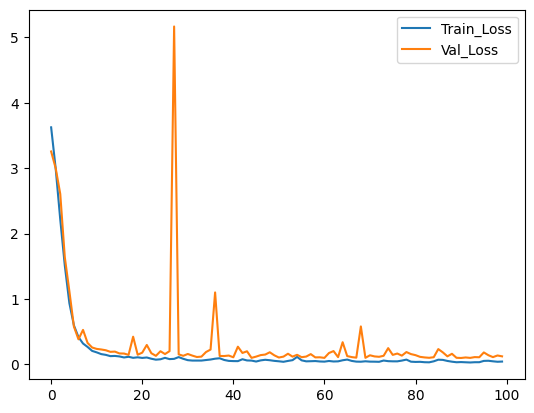

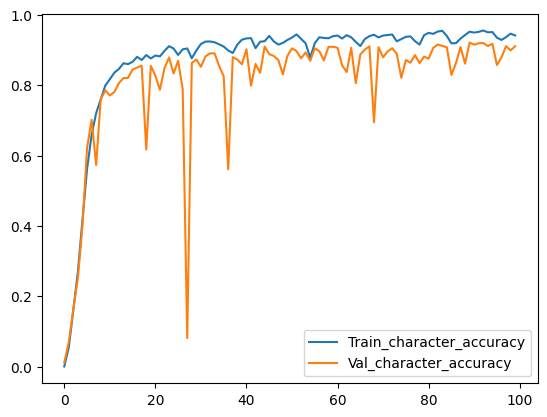

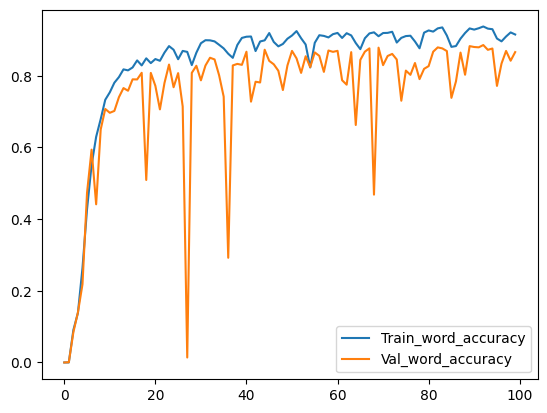

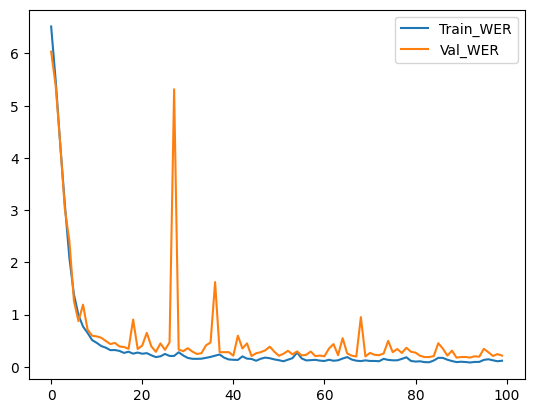

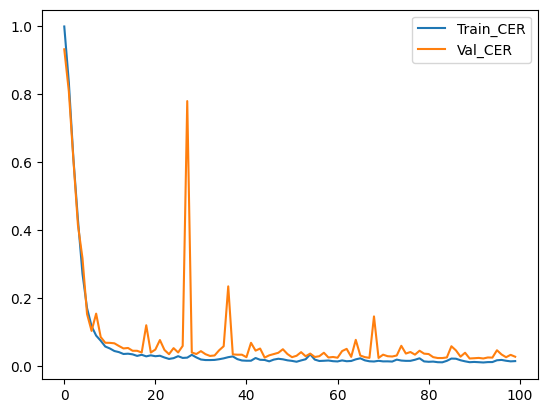

<Figure size 640x480 with 0 Axes>

In [17]:
import importlib
import Scripts.Train as Train
importlib.reload(Train)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = {"path": "Models/checkpoints/v0.01","log_path":"Logs", "metrics":["Train_Loss", "Val_Loss", "Train_CER" , "Val_character_accuracy", "Train_word_accuracy"]}
plots = {"path": "Plots"}
train_CRNN = Train.Train(train_loader = train_data, val_loader = val_data, criterion=criterion, optimizer=optimizer, device = device, char_to_index=char_to_index, metrics=["character_accuracy", "word_accuracy", "WER", "CER"], num_epochs=100)
train_CRNN.fit(model=model,plots = plots, checkpoint= checkpoint)

In [69]:
def OCR(image , char_to_index):
  model.eval()
  transformed_image = train_transforms(image)
  model_input = transformed_image.unsqueeze(0)
  x = model_input.to(device)
  model_output = model(x)
  model_output = model_output.permute(1, 0, 2)
  predictions = model_output.argmax(2).transpose(0, 1).cpu().numpy()
  predictions = ctc_decode(predictions, blank=0)
  print(predictions)
  results = []
  for text in predictions:
    text_output = [list(char_to_index.keys())[list(char_to_index.values()).index(index)] for index in text ]
    results.append(text_output)
  return results


In [102]:
image = Image.open("/content/persian_unique_ocr_dataset/04558_156_35334.png").convert("RGB")

In [79]:
test = pd.read_csv("/content/test_df.csv")
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
test.head(10)

,index,label,page,top_left_y,bot_right_y,top_left_x,bot_right_x,path
0,518242,اغماض،,4964,520,550,45,103,04964_166_518242.png
1,648841,مرجعیت,5210,645,675,203,260,05210_164_648841.png
2,543131,تأثر،,4692,610,640,428,462,04692_131_543131.png
3,579292,همکاریشیما,5069,625,655,45,129,05069_183_579292.png
4,652706,داستان‌نویس،,5066,520,550,199,295,05066_145_652706.png
5,1015608,وفقط,4284,450,480,227,264,04284_139_1015608.png
6,35334,صحرایی,4558,610,640,348,408,04558_156_35334.png
7,141224,دریافت.,3445,380,410,452,512,03445_105_141224.png
8,39708,قطار,3051,135,165,190,222,03051_25_39708.png
9,37847,افشای,4444,330,360,525,575,04444_74_37847.png
